In [1]:
import os
os.environ['OMP_NUM_THREADS']='2'
os.environ['LD_LIBRARY_PATH']=''
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [2]:
from data_generation import *
from utils import *
from upscaling import UpScale
from scipy.linalg import sqrtm
from downscaling import *

/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
N_low = 16
N_high = 64
l = 0.5
sigma = 0.01

In [4]:
w_low, r_low, A_low, x_low, y_low = generate_data(N_low)
w_high, r_high, A_high, x_high, y_high = generate_data(N_high)

In [18]:
with h5py.File('data/high_data', 'r') as hf:
    data1 = hf['high_res'][:]

with h5py.File('data/low_data', 'r') as hf:
    data2 = hf['low_res'][:]

In [21]:
epoch_num = 50
batch_size = 8
lr = 0.01
gamma = 0.5
minimum_loss = float('inf')
loss_track = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load training data
trainset = DataFromH5File("data/high_data","data/low_data")
train_loader = data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)

# Initialise training model
G = DownScale()
G.apply(weights_init_xavier).to(device)
mse = nn.MSELoss(reduction='sum')
optG = torch.optim.Adam(G.parameters(), lr = lr, weight_decay=0, betas=(0.5, 0.999))
r_scheduleG = torch.optim.lr_scheduler.StepLR(optG, step_size=50, gamma=gamma)

# Logger info
dir_name = f'models/downscaling/100samples/lr{lr}_gamma{gamma}'
makedir(dir_name)
logger = setup_logging('job0', dir_name, console=True)
logger.info(f'Training for {epoch_num} epoches and learning rate is {lr}')

for epoch in range(1, epoch_num+1):
    
    for i, d in enumerate(train_loader, 0):
        
        lr, hr = d
        size = lr.shape[0]
        lr = lr.to(device).reshape(size,1,N_low,N_low)
        hr = hr.to(device).reshape(size,1,N_high,N_high)
        
        optG.zero_grad()
        sr = G(hr)
        loss = mse(sr,lr)/batch_size
        loss.backward()
        optG.step()
        
        if loss < minimum_loss:
            save_model(dir_name, epoch, 'best_model', r_scheduleG, G, optG)
            minimum_loss = loss
            
        if epoch%100 == 0:
            save_model(dir_name, epoch, 'model_epoch_{}'.format(epoch), r_scheduleG, G, optG)
            
        loss_track.append(loss.cpu().data.numpy())
        np.save(f'{dir_name}/chains/loss_curve.npy', np.array(loss_track))
        
        print("Epoch:", epoch, "Loss:", loss)

        r_scheduleG.step()

Output directory already exists
2024-02-07 23:09:37,823 : Training for 50 epoches and learning rate is 0.01


/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([8, 1, 16, 16])) that is different to the input size (torch.Size([8, 10, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Loss: tensor(5082.5708, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2145.4238, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(1696.4873, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(4329.9858, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2388.6714, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(2751.5337, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(758.6490, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(656.2687, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(225.7536, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(1011.9188, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(373.8125, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 1 Loss: tensor(407.2926, device='cuda:0', grad_fn=<DivBackward0>)


/home/pz281@ad.eng.cam.ac.uk/anaconda3/envs/torch/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([4, 1, 16, 16])) that is different to the input size (torch.Size([4, 10, 16, 16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1 Loss: tensor(81.6910, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(599.3064, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(172.5198, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(253.3276, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(209.3400, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(153.0316, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(140.7788, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(253.3271, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(162.4700, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(257.0568, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(194.0888, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(312.9543, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(187.5579, device='cuda:0', grad_fn=<DivBackward0>)
Epoch: 2 Loss: tensor(81.2234, device='cuda:0', grad

KeyboardInterrupt: 

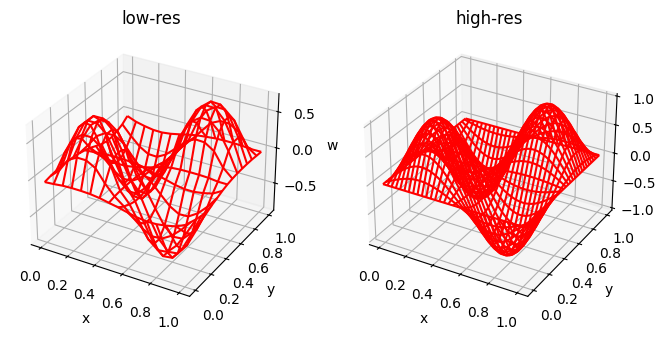

In [24]:
G = DownScale().to(device)
G.load_state_dict(torch.load('models/downscaling/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
input = w_high
input = torch.tensor(input.reshape(1,input.shape[0],-1))
input = input.to(torch.float32).to(device)
output = G(input)
y_input = input.cpu().detach().numpy()
y = output.cpu().detach().numpy()

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, y[0].reshape(16,16),color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, input[0].cpu().detach().numpy().reshape(64,64),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()


In [25]:
def sqrt_matrix(M):
    """
    Work out square root of a positive definite matrix
    """
    return sqrtm(M.cpu().data.numpy())

In [27]:
# Parameters for Langevin dynamics
K = 100
s = 0.0001
ll_sigma = 0.01
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mean_u, covariance_u = u_low_prior(l,sigma,N_high)
covariance = torch.tensor(covariance_u).to(device).to(torch.float32)
positive_covariance = covariance + 1e-5 * torch.eye(4096).to(device)
sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)

/tmp/ipykernel_603318/1179310990.py:10: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/Copy.cpp:250.)
  sqrt_covariance = torch.tensor(sqrt_matrix(positive_covariance)).to(device).to(torch.float32)


In [28]:

def sample_p_data():
    data = torch.tensor(data2.reshape(100,1,16,16)).to(torch.float32).to(device)
    return data[torch.LongTensor(batch_size).random_(0,100)].detach()

def sample_p_0(batch_size):
    # Randomly sampling for initialisation of the Langevin dynamics
    # prior = torch.randn(*[batch_size,1,20,20]).to(device)
    
    # Set the u_low_mean to the initialisation of the Langevin dynamics
    mean = w_high.reshape(1,1,N_high,N_high)
    b = np.repeat(mean,batch_size,axis=0)
    prior = torch.tensor(b).to(device).to(torch.float32)
    prior = prior + 0.1 * torch.rand_like(prior)
    
    return prior

def calculate_log_likelihood(x_hat,x,batch_size):
    ll = -1/(2*math.pow(ll_sigma, 2)) * torch.matmul((x-x_hat).reshape(batch_size,1,N_high**2),(x-x_hat).reshape(batch_size,N_high**2,1))
    # ll = -1/(2*math.pow(ll_sigma, 2)) * mse(x_hat,x)
    # ll = -torch.norm(x - x_hat, dim=-1) ** 2. / (2. * ll_sigma ** 2.)
    return ll.sum()
       
    
def ula_posterior(z, x, G):
    """
    Langevin dynamics without preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    for i in range(K):
        # Grad log-likelihood
        x_hat = G(z)
        log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
        grad_log_likelihood = torch.autograd.grad(log_likelihood, z)[0]
        
        # Grad prior
        w_high_tensor = torch.tensor(w_high).to(device).to(torch.float32)
        difference = z.reshape(batch_size,1,N_high**2) - w_high_tensor.reshape(1,N_high**2)
        grad_log_prior = -torch.linalg.solve(covariance, difference.reshape(batch_size,N_high**2,1)).reshape(batch_size,1,N_high,N_high)
        
        # Random noise term
        W = torch.randn(*[batch_size,1,N_high,N_high]).to(device)
        
        z = z + s**2 * grad_log_prior + s**2 * grad_log_likelihood + torch.sqrt(torch.tensor(2.)) * s * W
        chains_evolution.append(z.cpu().data.numpy())   
           
    return z.detach(), chains_evolution


def ula_posterior_preconditioner(z, x, G):
    """
    Langevin dynamics with preconditioner
    """
    z = z.clone().detach().requires_grad_(True)
    chains_evolution = []
    preconditioner = covariance
    for i in range(K):
        # Grad log-likelihood
        x_hat = G(z)
        log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
        grad_ll = torch.autograd.grad(log_likelihood, z)[0]
        grad_log_likelihood = torch.matmul(preconditioner,grad_ll.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)
        
        # Grad prior
        w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
        difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
        grad_log_prior = - difference.reshape(batch_size,1,N_low,N_low)
        
        # Random noise term
        W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)
        random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)
        
        z = z + s**2 * grad_log_prior + s**2 * grad_log_likelihood + torch.sqrt(torch.tensor(2.)) * s * random
        chains_evolution.append(z.cpu().data.numpy())   
           
    return z.detach(), chains_evolution

In [29]:
x = sample_p_data()
z = sample_p_0(batch_size)
z = z.clone().detach().requires_grad_(True)

In [33]:
x_hat.shape

torch.Size([8, 10, 16, 16])

In [32]:
G = DownScale().to(device)
G.load_state_dict(torch.load('models/downscaling/100samples/lr0.01_gamma0.5/ckpt/best_model.pth')['netG'])
x_hat = G(z)
log_likelihood = calculate_log_likelihood(x_hat,x,batch_size)
grad_ll = torch.autograd.grad(log_likelihood, z)[0]
grad_log_likelihood = torch.matmul(covariance,grad_ll.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)

# Grad prior
w_low_tensor = torch.tensor(w_low).to(device).to(torch.float32)
difference = z.reshape(batch_size,1,N_low**2) - w_low_tensor.reshape(1,N_low**2)
grad_log_prior = - difference.reshape(batch_size,1,N_low,N_low)

# Random noise term
W = torch.randn(*[batch_size,1,N_low,N_low]).to(device)
random = torch.matmul(sqrt_covariance,W.reshape(batch_size,N_low**2,1)).reshape(batch_size,1,N_low,N_low)

z = z + 0.5 * s ** 2 * grad_log_prior + 0.5 * s ** 2 * grad_log_likelihood + s * random

RuntimeError: shape '[8, 1, 4096]' is invalid for input of size 20480

In [ ]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121, projection='3d')
X, Y = np.meshgrid(x_low, y_low)
ax1.plot_wireframe(X, Y, z.cpu().data.numpy().reshape(32,20,20)[0],color='r')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('w')
ax1.set_title('low-res')
ax2 = fig.add_subplot(122, projection='3d')
X, Y = np.meshgrid(x_high,y_high)
ax2.plot_wireframe(X, Y, x.detach().cpu()[0][0].reshape(100,100),color='r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('w')
ax2.set_title('high-res')
plt.show()